In [1]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from doe_lhs import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
from torch.utils.data import TensorDataset, DataLoader

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

# Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, net, X_lb, X_ub, device):
        
        
        self.batch_size = 100000
        
        # boundary conditions
        self.X_lb = X_lb
        self.X_ub = X_ub
        
        self.device = device
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = net
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.Adam_optim = torch.optim.Adam(
            self.dnn.parameters(),
            lr = 1e-4
        )

        self.iter = 0
        
        shuffle = True
        self.train_loader = DataLoader(
            list(zip(self.x_u,
                     self.t_u,
                     self.u)), batch_size=self.batch_size, shuffle=shuffle
        )
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        
        h = self.net_u(x, t)
        u = h[:,0:1]
        v = h[:,1:2]
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_t = torch.autograd.grad(
            v, t, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u 
        return h,f_u, f_v
    
    def boundary_loss(self):
        
        x_lb = torch.tensor(self.X_lb[:, 0:1], requires_grad=True).float().to(self.device)
        t_lb = torch.tensor(self.X_lb[:, 1:2], requires_grad=True).float().to(self.device)

        x_ub = torch.tensor(self.X_ub[:, 0:1], requires_grad=True).float().to(self.device)
        t_ub = torch.tensor(self.X_ub[:, 1:2], requires_grad=True).float().to(self.device)
        
        y_pred_lb = self.dnn.forward(torch.cat([x_lb, t_lb], dim=1))
        y_pred_ub = self.dnn.forward(torch.cat([x_ub, t_ub], dim=1))
        
        u_lb = y_pred_lb[:,0:1]
        v_lb = y_pred_lb[:,1:2]
        u_ub = y_pred_ub[:,0:1]
        v_ub = y_pred_ub[:,1:2]
        
        u_lb_x = torch.autograd.grad(
                u_lb, x_lb, 
                grad_outputs=torch.ones_like(u_lb),
                retain_graph=True,
                create_graph=True
            )[0]

        u_ub_x = torch.autograd.grad(
                u_ub, x_ub, 
                grad_outputs=torch.ones_like(u_ub),
                retain_graph=True,
                create_graph=True
            )[0]

        v_lb_x = torch.autograd.grad(
                v_lb, x_lb, 
                grad_outputs=torch.ones_like(v_lb),
                retain_graph=True,
                create_graph=True
            )[0]

        v_ub_x = torch.autograd.grad(
                v_ub, x_ub, 
                grad_outputs=torch.ones_like(v_ub),
                retain_graph=True,
                create_graph=True
            )[0]
        
        loss = torch.mean((y_pred_lb - y_pred_ub)**2) + \
               torch.mean((u_lb_x - u_ub_x)**2) + \
               torch.mean((v_lb_x - v_ub_x)**2)
        
        return loss
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        _, f_u, f_v = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_u**2 + f_v**2)
        
        b_loss = self.boundary_loss()
        
        loss = loss_u + loss_f + b_loss
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self, epoch = 10000):
        self.train_1(epoch)
        self.train_2()
    
    def train_1(self,epoch):
        for e in range(epoch):
            
            for i, (x, t, y) in enumerate(self.train_loader):
            
            
                self.dnn.train()
                self.optimizer.zero_grad()

                u_pred = self.net_u(x, t)
#                 u_pred = self.net_u(self.x_u, self.t_u)
                _, f_u, f_v = self.net_f(self.x_f, self.t_f)
                loss_u = torch.mean((y - u_pred) ** 2)
                loss_f = torch.mean(f_u**2 + f_v**2)
                b_loss = self.boundary_loss()

                loss = loss_u + loss_f + b_loss

                loss.backward(retain_graph = True)
                self.Adam_optim.step()


                self.iter += 1
                if self.iter % 100 == 0:
                    print(
                        'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
                    )

    def train_2(self):
        self.dnn.train()
        self.optimizer.step(self.loss_func)
            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [5]:
# the physics-guided neural network
class D_PhysicsInformedNN():
    def __init__(self, 
                 X_u,
                 X_u_ts,
                 u,
                 u_ts,
                 X_f_1,
                 X_f_2,
                 net,
                 X_lb_1,
                 X_ub_1,
                 X_lb_2,
                 x_ub_2,
                 device):
        
        self.batch_size = 100000
        
        # boundary conditions
        
        self.X_lb = np.vstack([X_lb_1, X_lb_2])
        self.X_ub = np.vstack([X_ub_1, X_ub_2])
    
        self.device = device
        
        # data
        X_f = np.vstack([X_f_1, X_f_2])
        
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.x_u_ts = torch.tensor(X_u_ts[:, 0:1], requires_grad=True).float().to(device)
        self.t_u_ts = torch.tensor(X_u_ts[:, 1:2], requires_grad=True).float().to(device)
        self.u_ts = torch.tensor(u_ts).float().to(device)
        
        self.u_weights = torch.rand((X_u_ts.shape[0], 1), requires_grad=True)
        
        # deep neural networks
        self.dnn = net
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.Adam_optim = torch.optim.Adam(
            self.dnn.parameters(),
            lr = 1e-4
        )
        
        self.Adam_optim_u = torch.optim.Adam(
                [self.u_weights],
                lr = 5e-2
        )

        self.iter = 0
        
        shuffle = True
        self.train_loader = DataLoader(
            list(zip(self.x_u,
                     self.t_u,
                     self.u)), batch_size=self.batch_size, shuffle=shuffle
        )
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        
        h = self.net_u(x, t)
        u = h[:,0:1]
        v = h[:,1:2]
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_t = torch.autograd.grad(
            v, t, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u 
        return h,f_u, f_v
    
    def boundary_loss(self):
        
        x_lb = torch.tensor(self.X_lb[:, 0:1], requires_grad=True).float().to(self.device)
        t_lb = torch.tensor(self.X_lb[:, 1:2], requires_grad=True).float().to(self.device)

        x_ub = torch.tensor(self.X_ub[:, 0:1], requires_grad=True).float().to(self.device)
        t_ub = torch.tensor(self.X_ub[:, 1:2], requires_grad=True).float().to(self.device)
        
        y_pred_lb = self.dnn.forward(torch.cat([x_lb, t_lb], dim=1))
        y_pred_ub = self.dnn.forward(torch.cat([x_ub, t_ub], dim=1))
        
        u_lb = y_pred_lb[:,0:1]
        v_lb = y_pred_lb[:,1:2]
        u_ub = y_pred_ub[:,0:1]
        v_ub = y_pred_ub[:,1:2]
        
        u_lb_x = torch.autograd.grad(
                u_lb, x_lb, 
                grad_outputs=torch.ones_like(u_lb),
                retain_graph=True,
                create_graph=True
            )[0]

        u_ub_x = torch.autograd.grad(
                u_ub, x_ub, 
                grad_outputs=torch.ones_like(u_ub),
                retain_graph=True,
                create_graph=True
            )[0]

        v_lb_x = torch.autograd.grad(
                v_lb, x_lb, 
                grad_outputs=torch.ones_like(v_lb),
                retain_graph=True,
                create_graph=True
            )[0]

        v_ub_x = torch.autograd.grad(
                v_ub, x_ub, 
                grad_outputs=torch.ones_like(v_ub),
                retain_graph=True,
                create_graph=True
            )[0]
        
        loss = torch.mean((y_pred_lb - y_pred_ub)**2) + \
               torch.mean((u_lb_x - u_ub_x)**2) + \
               torch.mean((v_lb_x - v_ub_x)**2)
        
        return loss
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        _, f_u, f_v = self.net_f(self.x_f, self.t_f)
        
        u_ts_pred = self.net_u(self.x_u_ts,self.t_u_ts)
        _, f_u_ts, f_v_ts = self.net_f(self.x_u_ts,self.t_u_ts)
        
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_u**2 + f_v**2)
        
        loss_u_ts = torch.mean((self.u_ts - u_ts_pred)**2)
        loss_f_ts = torch.mean(f_u_ts**2 + f_v_ts**2)
        
        b_loss = self.boundary_loss()
        
        loss = loss_u + loss_f + b_loss + loss_u_ts + loss_f_ts
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self, epoch = 10000):
        self.train_1(epoch)
        self.train_2()
    
    def train_1(self,epoch):
        for e in range(epoch):
            
            for i, (x, t, y) in enumerate(self.train_loader):
            
                self.dnn.train()
                self.optimizer.zero_grad()
                self.Adam_optim_u.zero_grad()

                u_pred = self.net_u(x, t)
                _, f_u, f_v = self.net_f(self.x_f, self.t_f)
                
                u_ts_pred = self.net_u(self.x_u_ts,self.t_u_ts)
                _, f_u_ts, f_v_ts = self.net_f(self.x_u_ts,self.t_u_ts)
                
                loss_u = torch.mean((y - u_pred) ** 2)
                loss_f = torch.mean(f_u**2 + f_v**2)
                
                loss_u_ts = torch.mean((self.u_ts - (self.u_weights.float().to(device) * u_ts_pred))**2)
                loss_f_ts = torch.mean(f_u_ts**2 + f_v_ts**2)
                
                b_loss = self.boundary_loss()

                loss = loss_u + loss_f + b_loss + loss_u_ts + loss_f_ts

                loss.backward(retain_graph = True)
                self.Adam_optim.step()
                self.Adam_optim_u.step()

                self.iter += 1
                if self.iter % 100 == 0:
                    print(
                        'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
                    )

    def train_2(self):
        self.dnn.train()
        self.optimizer.step(self.loss_func)
            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [6]:
N0 = 50
N_b = 50
N_f = 10000
layers = [2, 100, 100, 100, 100, 2]

data = scipy.io.loadmat('../../../datasets/NLS.mat')

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

###########################

st = 0.30
tt = int(t.shape[0] * st)


trunk1_X = X_star[ : x.shape[0] * tt]
trunk2_X = X_star[ x.shape[0] * (tt - 1) : ]

trunk1_u = u_star[ : x.shape[0] * tt]
trunk2_u = u_star[ x.shape[0] * (tt - 1) : ]

trunk1_v = v_star[ : x.shape[0] * tt]
trunk2_v = v_star[ x.shape[0] * (tt - 1) : ]

trunk1_h = h_star[ : x.shape[0] * tt]
trunk2_h = h_star[ x.shape[0] * (tt - 1) : ]

###########################

lb = X_star.min(0)  # [-5.  0.]
ub = X_star.max(0)  # [4.9609375  1.57079633]

first_lb = trunk1_X.min(0) # [-5.  0.]
first_ub = trunk1_X.max(0) # [4.9609375  0.77754418]

second_lb = trunk2_X.min(0) # [-5.       0.77754418]
second_ub = trunk2_X.max(0) # [4.9609375  1.57079633]

###########################



# initial points
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0_1 = x[idx_x,:]
u0_1 = Exact_u[idx_x,0:1]
v0_1 = Exact_v[idx_x,0:1]

# boundary points
idx_t = np.random.choice(tt, N_b, replace=False)
tb_1 = t[idx_t,:]

# collocation points
X_f_1 = first_lb + (first_ub-first_lb)*lhs(2, N_f)


X0_1 = np.concatenate((x0_1, 0*x0_1), 1) # (x0, 0)
Y0_1 = np.concatenate((u0_1,v0_1), 1) 
X_lb_1 = np.concatenate((0*tb_1 + first_lb[0], tb_1), 1) # (lb[0], tb)
X_ub_1 = np.concatenate((0*tb_1 + first_ub[0], tb_1), 1) # (ub[0], tb)
   
    
net = DNN(layers).to(device)
model = PhysicsInformedNN(X0_1, Y0_1, X_f_1, net, X_lb_1,X_ub_1,device)

In [7]:
%%time
model.train()

Iter 100, Loss: 1.33345e-01, Loss_u: 1.10091e-01, Loss_f: 1.47111e-02
Iter 200, Loss: 9.39949e-02, Loss_u: 7.41656e-02, Loss_f: 1.41496e-02
Iter 300, Loss: 6.47013e-02, Loss_u: 4.75908e-02, Loss_f: 1.34531e-02
Iter 400, Loss: 5.02502e-02, Loss_u: 3.53174e-02, Loss_f: 1.26143e-02
Iter 500, Loss: 4.29300e-02, Loss_u: 2.92946e-02, Loss_f: 1.23940e-02
Iter 600, Loss: 3.85320e-02, Loss_u: 2.63766e-02, Loss_f: 1.15793e-02
Iter 700, Loss: 3.22787e-02, Loss_u: 2.31691e-02, Loss_f: 8.85742e-03
Iter 800, Loss: 2.25641e-02, Loss_u: 1.72736e-02, Loss_f: 5.16867e-03
Iter 900, Loss: 1.64851e-02, Loss_u: 1.19894e-02, Loss_f: 4.44657e-03
Iter 1000, Loss: 1.47673e-02, Loss_u: 9.89218e-03, Loss_f: 4.60599e-03
Iter 1100, Loss: 1.31774e-02, Loss_u: 8.83402e-03, Loss_f: 4.30282e-03
Iter 1200, Loss: 1.22374e-02, Loss_u: 8.05346e-03, Loss_f: 4.12003e-03
Iter 1300, Loss: 1.13155e-02, Loss_u: 7.46572e-03, Loss_f: 3.81685e-03
Iter 1400, Loss: 1.06184e-02, Loss_u: 6.91163e-03, Loss_f: 3.67764e-03
Iter 1500, Loss

Iter 11700, Loss: 1.73578e-05, Loss_u: 5.08928e-06, Loss_f: 1.13567e-05
Iter 11800, Loss: 1.63657e-05, Loss_u: 4.95109e-06, Loss_f: 1.05357e-05
Iter 11900, Loss: 1.52491e-05, Loss_u: 4.65452e-06, Loss_f: 9.85797e-06
Iter 12000, Loss: 1.43813e-05, Loss_u: 4.33745e-06, Loss_f: 9.30134e-06
Iter 12100, Loss: 1.35157e-05, Loss_u: 4.01456e-06, Loss_f: 8.77196e-06
Iter 12200, Loss: 1.29818e-05, Loss_u: 3.96482e-06, Loss_f: 8.30419e-06
Iter 12300, Loss: 1.23247e-05, Loss_u: 3.79971e-06, Loss_f: 7.83792e-06
Iter 12400, Loss: 1.16972e-05, Loss_u: 3.67407e-06, Loss_f: 7.32633e-06
Iter 12500, Loss: 1.11212e-05, Loss_u: 3.53047e-06, Loss_f: 6.90010e-06
Iter 12600, Loss: 1.05099e-05, Loss_u: 3.37609e-06, Loss_f: 6.49316e-06
Iter 12700, Loss: 9.94991e-06, Loss_u: 3.23575e-06, Loss_f: 6.13122e-06
Iter 12800, Loss: 9.34825e-06, Loss_u: 3.02080e-06, Loss_f: 5.84251e-06
Iter 12900, Loss: 8.91494e-06, Loss_u: 2.89766e-06, Loss_f: 5.59767e-06
Iter 13000, Loss: 8.58595e-06, Loss_u: 2.85465e-06, Loss_f: 5.32

In [8]:
nsamples = 1
u_pred_list = []
v_pred_list = []
h_pred_list = []
f_u_pred_list = []
f_v_pred_list = []

xxx = torch.tensor(trunk1_X[:,0:1], requires_grad=True).float().to(device)
ttt = torch.tensor(trunk1_X[:,1:2], requires_grad=True).float().to(device)

for run in range(nsamples):
    y_pred, f_u_pred, f_v_pred = model.net_f(xxx,ttt)
    u_pred = y_pred[:,0:1].detach().cpu().numpy()
    v_pred = y_pred[:,1:2].detach().cpu().numpy()
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    u_pred_list.append(u_pred)
    v_pred_list.append(v_pred)
    f_u_pred_list.append(f_u_pred.detach().cpu().numpy())
    f_v_pred_list.append(f_v_pred.detach().cpu().numpy())
    h_pred_list.append(h_pred)


u_pred_arr = np.array(u_pred_list)
v_pred_arr = np.array(v_pred_list)
f_u_pred_arr = np.array(f_u_pred_list)
f_v_pred_arr = np.array(f_v_pred_list)
h_pred_arr = np.array(h_pred_list)

u_pred = u_pred_arr.mean(axis=0)
v_pred = v_pred_arr.mean(axis=0)
f_u_pred = f_u_pred_arr.mean(axis=0)
f_v_pred = f_v_pred_arr.mean(axis=0)
h_pred = h_pred_arr.mean(axis=0)

h_pred_var = h_pred_arr.var(axis=0)
residual = (f_u_pred**2).mean() + (f_v_pred**2).mean()


error_u = np.linalg.norm(trunk1_u-u_pred,2)/np.linalg.norm(trunk1_u,2)
error_v = np.linalg.norm(trunk1_v-v_pred,2)/np.linalg.norm(trunk1_v,2)
error_h = np.linalg.norm(trunk1_h-h_pred,2)/np.linalg.norm(trunk1_h,2)

print("Error u:", error_u)
print("Error v:", error_v)
print("Error h:", error_h)                   
print('Residual: %e' % (residual))

tmp_pred = h_pred[-256:]

Error u: 0.0021694765338356936
Error v: 0.002076625509824947
Error h: 0.001621814209858921
Residual: 1.714099e-06


In [9]:
N0 = 50
N_b = 50
N_f = 10000

# initial points
idx_x = np.random.choice(x.shape[0], 256, replace=False)

x0_2 = x[idx_x,:]
u0_2 = u_pred[-256:][idx_x,0:1]
v0_2 = v_pred[-256:][idx_x,0:1]

# boundary points
idx_t = np.random.choice(range(tt, 201), N_b, replace=False)
tb_2 = t[idx_t,:]

# collocation points
X_f_2 = second_lb + (second_ub-second_lb)*lhs(2, N_f)

X0_2 = np.concatenate((x[idx_x,:], 
                       np.full(x[idx_x,:].shape, first_ub[1])), 1) # (x0, 0)



Y0_2 = np.concatenate((u0_2,v0_2), 1) 
X_lb_2 = np.concatenate((0*tb_2 + second_lb[0], tb_2), 1) # (lb[0], tb)
X_ub_2 = np.concatenate((0*tb_2 + second_ub[0], tb_2), 1) # (ub[0], tb)

model = D_PhysicsInformedNN(X0_1, 
                            X0_2,
                            Y0_1,
                            Y0_2,
                            X_f_1,
                            X_f_2,
                            net, 
                            X_lb_1,
                            X_ub_1,
                            X_lb_2,
                            X_ub_2,
                            device)

In [10]:
%%time
model.train()

Iter 100, Loss: 5.01268e-01, Loss_u: 2.69617e-03, Loss_f: 4.55949e-01
Iter 200, Loss: 3.10765e-01, Loss_u: 4.03875e-03, Loss_f: 2.90431e-01
Iter 300, Loss: 2.23798e-01, Loss_u: 5.62250e-03, Loss_f: 2.07650e-01
Iter 400, Loss: 1.77777e-01, Loss_u: 6.64214e-03, Loss_f: 1.62518e-01
Iter 500, Loss: 1.48912e-01, Loss_u: 7.39735e-03, Loss_f: 1.33503e-01
Iter 600, Loss: 1.28389e-01, Loss_u: 8.14567e-03, Loss_f: 1.12483e-01
Iter 700, Loss: 1.12914e-01, Loss_u: 8.91781e-03, Loss_f: 9.63309e-02
Iter 800, Loss: 1.00952e-01, Loss_u: 9.62313e-03, Loss_f: 8.36800e-02
Iter 900, Loss: 9.15462e-02, Loss_u: 1.01747e-02, Loss_f: 7.37191e-02
Iter 1000, Loss: 8.40544e-02, Loss_u: 1.05779e-02, Loss_f: 6.58038e-02
Iter 1100, Loss: 7.80148e-02, Loss_u: 1.08600e-02, Loss_f: 5.94513e-02
Iter 1200, Loss: 7.30707e-02, Loss_u: 1.10461e-02, Loss_f: 5.42966e-02
Iter 1300, Loss: 6.89467e-02, Loss_u: 1.11642e-02, Loss_f: 5.00493e-02
Iter 1400, Loss: 6.54351e-02, Loss_u: 1.12387e-02, Loss_f: 4.64877e-02
Iter 1500, Loss

Iter 11700, Loss: 2.79377e-04, Loss_u: 7.97089e-06, Loss_f: 2.55320e-04
Iter 11800, Loss: 2.47634e-04, Loss_u: 8.64233e-06, Loss_f: 2.21395e-04
Iter 11900, Loss: 2.25285e-04, Loss_u: 6.91583e-06, Loss_f: 2.00174e-04
Iter 12000, Loss: 2.04218e-04, Loss_u: 7.50184e-06, Loss_f: 1.80379e-04
Iter 12100, Loss: 1.85539e-04, Loss_u: 6.34327e-06, Loss_f: 1.63896e-04
Iter 12200, Loss: 1.67330e-04, Loss_u: 6.61205e-06, Loss_f: 1.46144e-04
Iter 12300, Loss: 1.53662e-04, Loss_u: 6.54435e-06, Loss_f: 1.34844e-04
Iter 12400, Loss: 1.42496e-04, Loss_u: 5.61858e-06, Loss_f: 1.25408e-04
Iter 12500, Loss: 1.34025e-04, Loss_u: 6.16694e-06, Loss_f: 1.17170e-04
Iter 12600, Loss: 1.24025e-04, Loss_u: 5.21234e-06, Loss_f: 1.08495e-04
Iter 12700, Loss: 1.15830e-04, Loss_u: 5.63477e-06, Loss_f: 1.00736e-04
Iter 12800, Loss: 1.09318e-04, Loss_u: 5.39421e-06, Loss_f: 9.49893e-05
Iter 12900, Loss: 1.01735e-04, Loss_u: 4.89793e-06, Loss_f: 8.90600e-05
Iter 13000, Loss: 9.53344e-05, Loss_u: 5.05397e-06, Loss_f: 8.28

In [11]:
nsamples = 1
u_pred_list = []
v_pred_list = []
h_pred_list = []
f_u_pred_list = []
f_v_pred_list = []

x = torch.tensor(X_star[:,0:1], requires_grad=True).float().to(device)
t = torch.tensor(X_star[:,1:2], requires_grad=True).float().to(device)

for run in range(nsamples):
    y_pred, f_u_pred, f_v_pred = model.net_f(x,t)
    u_pred = y_pred[:,0:1].detach().cpu().numpy()
    v_pred = y_pred[:,1:2].detach().cpu().numpy()
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    u_pred_list.append(u_pred)
    v_pred_list.append(v_pred)
    f_u_pred_list.append(f_u_pred.detach().cpu().numpy())
    f_v_pred_list.append(f_v_pred.detach().cpu().numpy())
    h_pred_list.append(h_pred)


u_pred_arr = np.array(u_pred_list)
v_pred_arr = np.array(v_pred_list)
f_u_pred_arr = np.array(f_u_pred_list)
f_v_pred_arr = np.array(f_v_pred_list)
h_pred_arr = np.array(h_pred_list)

u_pred = u_pred_arr.mean(axis=0)
v_pred = v_pred_arr.mean(axis=0)
f_u_pred = f_u_pred_arr.mean(axis=0)
f_v_pred = f_v_pred_arr.mean(axis=0)
h_pred = h_pred_arr.mean(axis=0)

h_pred_var = h_pred_arr.var(axis=0)
residual = (f_u_pred**2).mean() + (f_v_pred**2).mean()

#     u_dev = u_pred_arr.var(axis=0)
#     f_dev = f_pred_arr.var(axis=0)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
H_pred_var = griddata(X_star, h_pred_var.flatten(), (X, T), method='cubic')
FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')

print("Error u:", error_u)
print("Error v:", error_v)
print("Error h:", error_h)                   
print('Residual: %e' % (residual))

Error u: 0.002275932801478758
Error v: 0.0031575172020313464
Error h: 0.0017366558163803686
Residual: 6.455330e-06


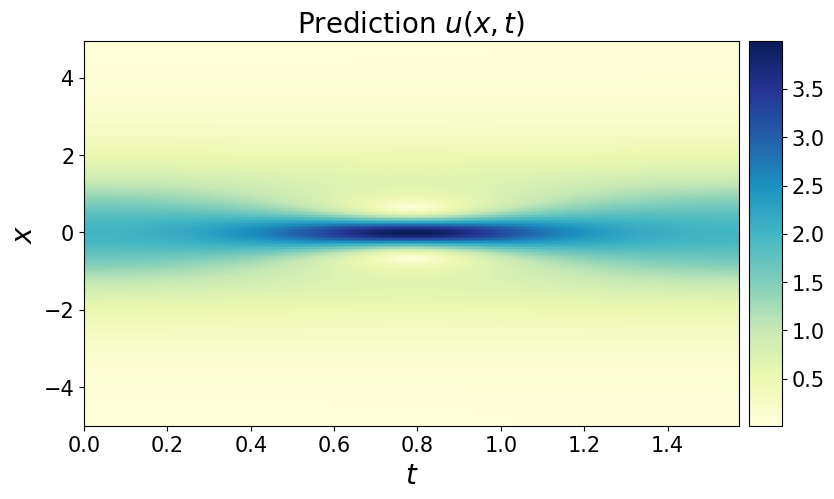

In [18]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact_h - H_pred.T)
""" The aesthetic setting has changed. """


xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# boundary conditions x = lb
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# boundary conditions, x = ub
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx2, xx3]) 


####### Row 0: u(t,x) ##################    
X_u_train_ = X_u_train

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]

# h = ax.imshow(Error, interpolation='nearest', cmap='YlGnBu', 
#               extent=[t.min(), t.max(), x.min(), x.max()], 
#               origin='lower', aspect='auto')

h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

# ax.plot(
#     X_u_train_[:,1], 
#     X_u_train_[:,0], 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# )


ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.set_title('Prediction $u(x,t)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.savefig('DP_Schro_Prediction.svg',dpi = 600, bbox_inches = 'tight')
plt.show()

/tmp/dcs-tmp.u1834031/ipykernel_407302/2990195499.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])


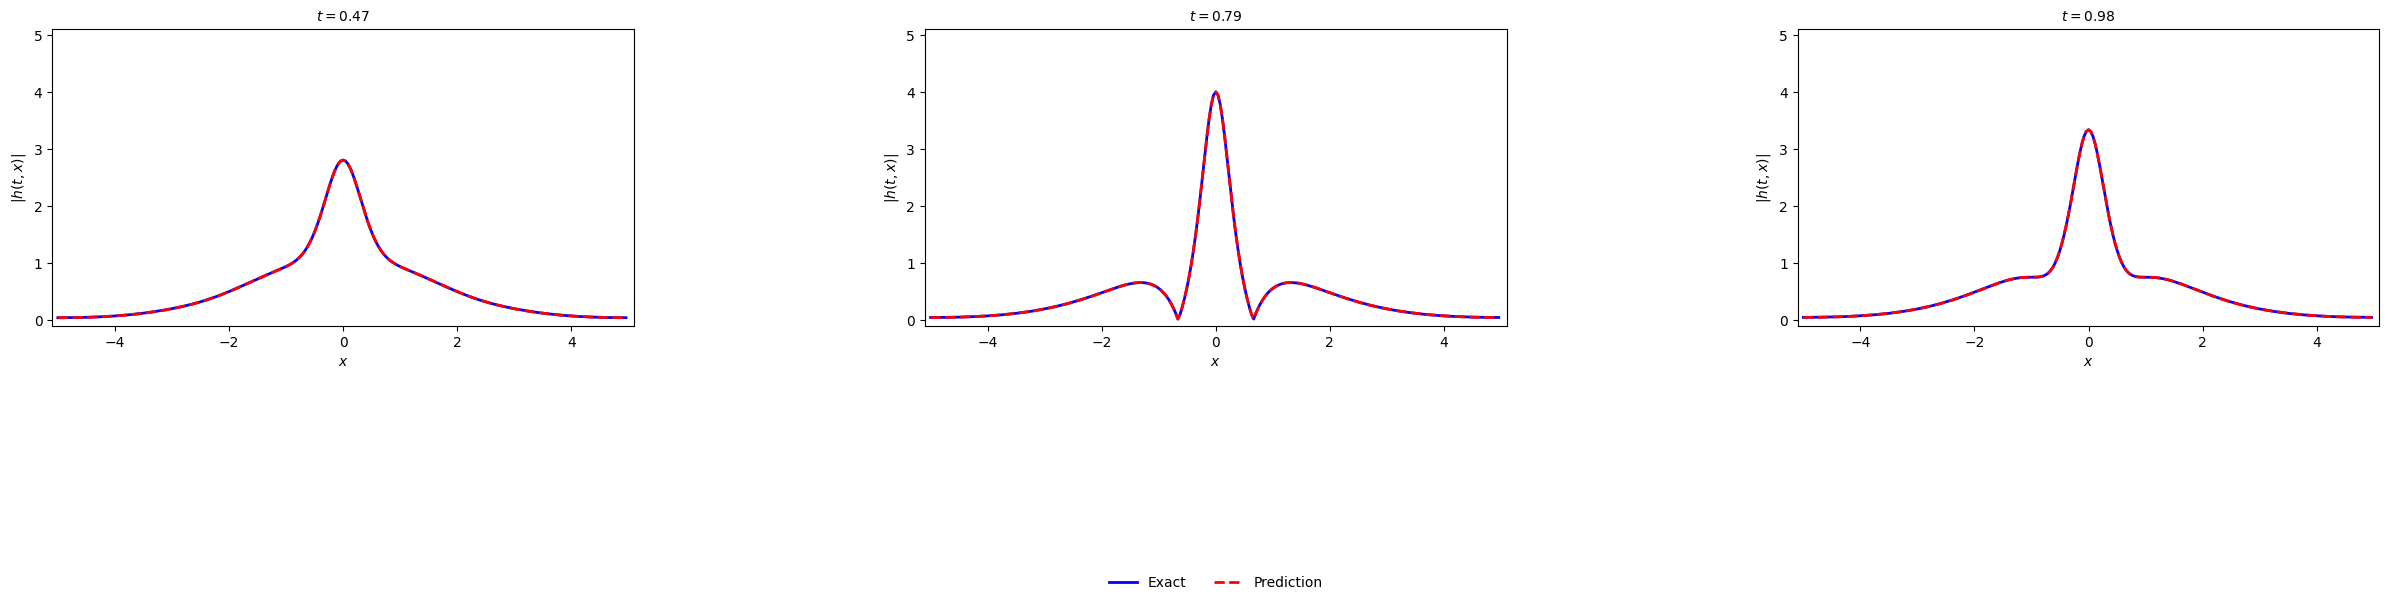

In [21]:
####### Row 1: h(t,x) slices ##################    
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(111)

st = 0.30
tt = int(t.shape[0] * st)

gs1 = gridspec.GridSpec(1, 4)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,tt], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[tt,:], 'r--', linewidth = 2, label = 'Prediction')

ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[tt]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')

ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')

ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)


plt.savefig('DP_Schro_times.svg',dpi = 600, bbox_inches = 'tight')

In [27]:
(np.sqrt((tmp_pred - trunk1_h[-256:])**2) / np.sqrt(trunk1_h[-256:] ** 2)).mean()

0.004821146934164661

In [35]:
(np.sqrt((tmp_pred - trunk1_h[-256:])**2) / np.sqrt(trunk1_h[-256:] ** 2)).mean()

0.004895126672946309

In [30]:
u_pred[15360-256:15360].shape

(256, 1)

In [29]:
trunk1_X.shape

(15360, 2)

In [34]:
nsamples = 1
u_pred_list = []
v_pred_list = []
h_pred_list = []
f_u_pred_list = []
f_v_pred_list = []

xxx = torch.tensor(trunk1_X[:,0:1], requires_grad=True).float().to(device)
ttt = torch.tensor(trunk1_X[:,1:2], requires_grad=True).float().to(device)

for run in range(nsamples):
    y_pred, f_u_pred, f_v_pred = model.net_f(xxx,ttt)
    u_pred = y_pred[:,0:1].detach().cpu().numpy()
    v_pred = y_pred[:,1:2].detach().cpu().numpy()
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    u_pred_list.append(u_pred)
    v_pred_list.append(v_pred)
    f_u_pred_list.append(f_u_pred.detach().cpu().numpy())
    f_v_pred_list.append(f_v_pred.detach().cpu().numpy())
    h_pred_list.append(h_pred)


u_pred_arr = np.array(u_pred_list)
v_pred_arr = np.array(v_pred_list)
f_u_pred_arr = np.array(f_u_pred_list)
f_v_pred_arr = np.array(f_v_pred_list)
h_pred_arr = np.array(h_pred_list)

u_pred = u_pred_arr.mean(axis=0)
v_pred = v_pred_arr.mean(axis=0)
f_u_pred = f_u_pred_arr.mean(axis=0)
f_v_pred = f_v_pred_arr.mean(axis=0)
h_pred = h_pred_arr.mean(axis=0)

h_pred_var = h_pred_arr.var(axis=0)
residual = (f_u_pred**2).mean() + (f_v_pred**2).mean()


error_u = np.linalg.norm(trunk1_u-u_pred,2)/np.linalg.norm(trunk1_u,2)
error_v = np.linalg.norm(trunk1_v-v_pred,2)/np.linalg.norm(trunk1_v,2)
error_h = np.linalg.norm(trunk1_h-h_pred,2)/np.linalg.norm(trunk1_h,2)

print("Error u:", error_u)
print("Error v:", error_v)
print("Error h:", error_h)                   
print('Residual: %e' % (residual))

tmp_pred = h_pred[-256:]

Error u: 0.0024128715828153303
Error v: 0.002378871080810136
Error h: 0.0017859673139533582
Residual: 3.527606e-06
